In [1]:
from mylab.ana.miniscope.context_exposure.Cminiana import MiniAna as MA
from mylab.ana.miniscope.context_exposure.Cminiana import Cellid 
from mylab.ana.miniscope.context_exposure.ana_funtions import *
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import glob,sys,os,re

# for part1
we could analysis **context cell**,**running direction cell** and **place cell**:
the change of the proportion along sessions.

## load data

In [2]:
file_path = r"\\10.10.46.135\Lab_Members\_Lab Data Analysis\02_Linear_Track\Miniscope_Linear_Track\batch3\Results_201033-finish\part1"
sessions = glob.glob(os.path.join(file_path,"session*.pkl"))
sessions
`
s = MA(sessions[8])

FUN:: _load_session
loading \\10.10.46.135\Lab_Members\_Lab Data Analysis\02_Linear_Track\Miniscope_Linear_Track\batch3\Results_201033-finish\part1\session9.pkl
loaded
dict_keys(['ms_ts', 'S_dff', 'sigraw', 'idx_accepted', 'corrected_ms_ts', 'behavevideo', 'behavelog_time', 'behavelog_info', 'behave_track', 'in_context_mask', 'in_context_coords', 'in_lineartrack_mask', 'in_lineartrack_coords', 'Trial_Num', 'process', 'behavevideoframe', 'all_track_points', 'aligned_behave2ms'])
'sigraw' is taken as original self.df


## Cellids of context, running direction and place cells

In [ ]:
c = Cellid(sessions[8])

meanfr,a,b,c = c.plot_in_context_placefield(context_map=["B","A","C","N"])

contextcells,rdcells,pccells = cellids(sessions[8],scale=0.33,placebin_number=40,shuffle_times=1000)

meanfr,a,b,c = c.plot_in_context_placefield(context_map=["B","A","C","N"])

## generate funtions for plot single cell

In [ ]:
Context_Matrix_info = SingleCell_MeanFr_in_SingleTrial_along_Placebin(
    s
    ,df=None
    ,contexts=None
    ,place_bins=list(np.arange(8,50)) # placebins only in context
    ,idxes = None
    ,trials=None)
print(Context_Matrix_info.keys())
plot,plot2 = plot_MeanFr_along_Placebin(Context_Matrix_info)

In [13]:
s.result.keys()

dict_keys(['ms_ts', 'S_dff', 'sigraw', 'idx_accepted', 'corrected_ms_ts', 'behavevideo', 'behavelog_time', 'behavelog_info', 'behave_track', 'in_context_mask', 'in_context_coords', 'in_lineartrack_mask', 'in_lineartrack_coords', 'Trial_Num', 'process', 'behavevideoframe', 'all_track_points', 'aligned_behave2ms', 'place_bin_No', 'Context'])

### looking through each cell idx by inputing different cellid

In [3]:
idx=5
context=0
plot(idx,context);plot2(idx)

'place_bin_No' has been added
'Contex' came frome 'Enter_ctx'
'Context' has been added
'Context' was represented as 0,1,2 or -1


dict_keys(['cellids', 'place_bins', 'trials', 'Context_Matrix_cellids_placebins_trials'])

## Context cell 

In [170]:
def SingleCell_trace_in_SingleTrial(s,df=None,contexts=None,place_bins=None,idxes=None,trials=None):
    """
    generate a dict containing lists of each context in which are dataframe of each trials
    the columns of the dataframe are [ms_ts,Body_speed_angle,idxes...]
    """
    df = s.df if df ==None else df
    cellids = s.result["idx_accepted"] if idxes == None else idxes
    if not idxes == None:
        df = df[cellids]
        print("screen df accoording to given idxes")

    # Trials is ready    
    ms_ts = pd.Series(s.result["ms_ts"])# ms_ts is ready
    s.add_Context(context_map=None) # add Contxt as a set of [0,1,2]
    s.add_alltrack_placebin_num(according = "Head",place_bin_nums=[4,4,40,4,4,4],behavevideo=None) # add "place_bin_No"
    s.add_Body_speed(scale=0.33) # Body_speed & Body_speed_angle are ready

    df["Context"] = s.result["Context"]
    df["place_bin_No"] = s.result["place_bin_No"] # used only in screen data in context. actually s.add_is_in_context is alternative way to screen this.
    df["Trial_Num"] = s.result["Trial_Num"]
    df["ms_ts"] = s.result["ms_ts"]
    df["Body_speed_angle"] = s.result["Body_speed_angle"]

    #screen contexts
    contexts = np.unique(s.result["Context"]) if contexts == None else contexts  
    df = df.loc[df["Context"].isin(contexts)]
#     print(contexts)
    print("screen df according to given contexts")

    #screen placebins
    placebins = np.unique(s.result["place_bin_No"]) if place_bins==None else place_bins
    df = df.loc[df["place_bin_No"].isin(placebins)]
    df.drop(columns="place_bin_No",inplace=True) 
#     print(placebins)
    print("screen df according to given place bins")

    #screen trials
    trials = np.unique(s.result["Trial_Num"]) if trials == None else trials
    df = df.loc[df["Trial_Num"].isin(trials)]
#     print(trials)
    print("screen df according to given tirals")
    

    Context_dataframe_info=dict()
    
    for context in np.unique(df["Context"]):
        if not context==-1:
            Trial_list_info = list()
            context_df = df[df["Context"]==context]
            context_df.drop(columns="Context",inplace=True)
            for trial in np.unique(context_df["Trial_Num"]):
                temp = context_df[context_df["Trial_Num"]==trial]
                temp.drop(columns="Trial_Num",inplace=True)
                Trial_list_info.append(temp) #Besides idxes only "ms_ts" and "Body_speed_angle" left
            Context_dataframe_info[context]=Trial_list_info

    return Context_dataframe_info

In [257]:
def plot_trace_with_running_direction(Context_dataframe_info):
    """
    return internal functions for plotting trace of each trial with two colors means two direction
    """
    def plot(idx,context):
        """
        return an inter function
            That could plot trace along each trial which have "ms_ts" and "Body_speed_angle" Besides idxes 
        """
        

        if context in Context_dataframe_info.keys():
            trials = Context_dataframe_info[context]

        else:
            print("Context %s doesn't exist."%context)
            return 

        trial_lens = len(trials)

        fig,axes = plt.subplots(trial_lens,1
                                ,figsize=(8,0.5*trial_lens)
                                ,subplot_kw = {"xticks":[],"yticks":[]}
                                )

        for i,ax in enumerate(axes):
            if i==0:
                ax.set_title("incontext(placebins) firing rate cellid:%s, context:%s"%(idx,context))
            if i==len(axes)-1:
                ax.set_xlabel("Trial Time(ctx enter > r-ctx_exit)")
            ax.set_ylabel(i+1,rotation=0)
#             ax.set_axis_off() 
            ax.spines['top'].set_visible(False)
#             ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            color=["red" if i>90 and i<280 else "green" for i in trials[i]["Body_speed_angle"]]
            ax.scatter(x=trials[i]["ms_ts"]-np.min(trials[i]["ms_ts"]),y=trials[i][idx],c=color,s=1)
        plt.show()
    return plot

In [171]:
Context_dataframe_info = SingleCell_trace_in_SingleTrial(s,place_bins=list(np.arange(8,50)))


'Context' was there
'Context' was represented as 0,1,2 or -1
'place_bin_No' has been there
Body_speed has been there
screen df according to given contexts
screen df according to given place bins
screen df according to given tirals


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Sabri\Anaconda3\envs\mylab\lib\logging\__init__.py", line 1029, in emit
    self.flush()
  File "C:\Users\Sabri\Anaconda3\envs\mylab\lib\logging\__init__.py", line 1009, in flush
    self.stream.flush()
FileNotFoundError: [Errno 2] No such file or directory
Call stack:
  File "C:\Users\Sabri\Anaconda3\envs\mylab\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Sabri\Anaconda3\envs\mylab\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Sabri\Anaconda3\envs\mylab\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Sabri\Anaconda3\envs\mylab\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Sabri\Anaconda3\envs\mylab\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Users\Sab

dict_keys([0, 1, 2])

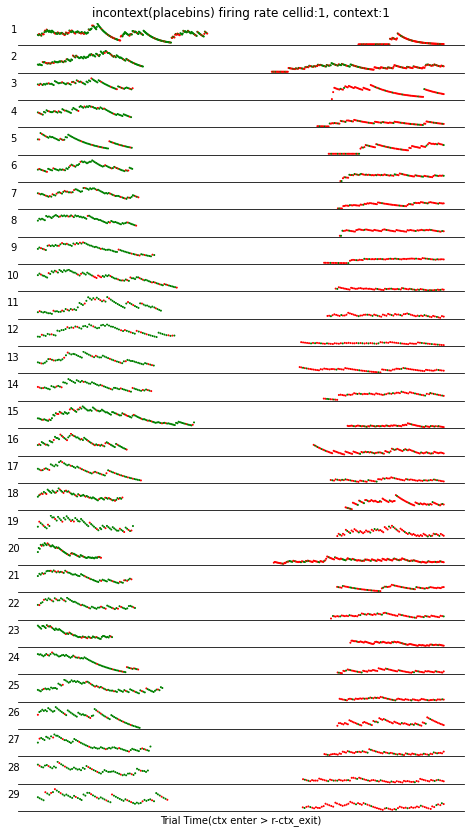

In [263]:
plot=plot_trace_with_running_direction(Context_dataframe_info)

plot(1,1)